## Molecular dynamic simulation of a mini-crystal in 2D
Created by: Emil Spasov

Last edited: 29.12.2023

Based on a project assignment in TFY4230 - Statistical Physics, NTNU Trondheim, Norway

This computational project will explore the statistical mechanics of a mini-crystal in two
dimensions. The particles in the crystal have kinetic energy and are held together by potential
energy (interactions). The motion of the particles is found by direct numerical integration of
Newton’s equations.

We shall consider M particles with positions given by the vectors $\vec{r_i} = (x_i, y_i)$. The
interaction energy between any two particles $i$ and $j$ is given by the Lennard-Jones potential:
$$ V_{ij} = 4\epsilon \left[ \left( \frac{a}{r_{ij}}\right)^{12} - \left( \frac{a}{r_{ij}}\right)^{6} \right] $$
where $r_{ij} = |\vec{r_i}−\vec{r_j}|$ is the distance between particle $i$ and $j$, and the strength of the interaction
is determined by the parameter  $\epsilon > 0$. The $\frac{1}{r}^{12}$ interaction is a short-ranged strong repulsive
interaction, and the $frac{1}{r}^6$ is an attractive interaction that is weaker but longer range. The
potential energy between two particles is at a minimum at the distance $r_0 \approx 1.12a$,
and the minimum energy is $−\epsilon$.

The force is repulsive when $r_{ij} < r_0$, and attractive when $r_{ij} > r_0$. The potential energy
increases fast when $r_{ij} < r_0$, and the length $r_0$ therefore roughly defines the size (diameter)
of particles. Newton’s equations of motion is then:

$$ m \frac{d^2\vec{r_i}}{dt^2} = \vec{f_i} = - \sum_{i\neq j} \frac{\partial V(r_{ij})}{\partial \vec{r_i}}$$

where $\vec{f_i}$ is the sum of all forces acting on particle $i$. The sum over $j$ goes through all particles, except the particle itself (no self-interaction). We are in the microcanonical situation, since the total energy is exactly constant (isolated system).

#### Numerical method:

Direct numerical integration of Newton’s equations with particles interacting through
some effective potentials, is commonly referred to as Molecular Dynamics simulations (MD).
The ”velocity Verlet algorithm” is a simple, yet very effective and stable method for numerically integrating Newtonian systems. At time $t = 0$ we set the initial particle positions $\vec{r_i}(0)$ and velocities $\vec{v_i}(0)$, and update to new positions and velocities at each timestep using:

$$ \vec{r_i}(t + \Delta t) = \vec{r_i}(t) + \vec{v_i}(t) \Delta t +\frac {\vec{f_i}(t)}{2m}\Delta t^2 $$
$$ \vec{v_i}(t + \Delta t) = \vec{v_i}(t) +\frac {\vec{f_i}(t) + \vec{f_i}(t+\Delta t)}{2m}\Delta t $$

The first equation can be understood as the Taylor series expansion of the particle positions as a function of time. In the second equation we update the particle velocities using an average of the force (acceleration) at times $t$ and $t + \Delta t$.


In [26]:
#import libraries

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [27]:
# define constants
a = 1           # length units
eps = 1         # strength of the interaction >0
m = 1           # mass


In [28]:
class Particle(object):

    """ 
        A class to represent a particle.

    Attributes
    ----------
        pos : ndarray, size(2)
            x, y position of the particle
        vel : ndarray, size(2)
            x, y velocity of the particle
        acc : ndarray, size(2)
            x, y acceleration of the particle

    Methods
    -------
        LJ_force(particles_arr):
            Calculates the accelleration due to the Lennard-Jones potential
        update_pos(dt):
            Update the position of the particle according to Verlet algorithm with timestep dt
        update_pos(acc_0, dt):
            Update the velocity of the particle according to Verlet algorithm with timestep dt
            
        """
    
    def __init__(self, pos, vel):

        """
        Constructs all the necessary attributes for the Particle object.

        Parameters
        ----------
            pos : ndarray, size(2)
                x, y position of the particle
            vel : ndarray, size(2)
                x, y velocity of the particle
        Returns
        -------
            None

        """

        self.pos = pos
        self.vel = vel
        self.acc = np.array((0,0))

    def __sub__(self, other):

        """ 
        Overloading operator "-" for objects of class Particle
        
        Parameters
        ----------
            other : Particle
                Instance of class particle
        
        Returns
        -------
            diff : ndarray, size(2)
                array with the difference between position of the particle object 
                and some other object of the same class
        """

        diff = np.array((other.pos[0] - self.pos[0], 
                            other.pos[1] - self.pos[1]))
        
        return diff
    
    def LJ_acc(self, particles_array, walls_pos = (-5, 10, -5, 10)):
        """
            Calculates the accelleration due to the Lennard-Jones potential
            with hard walls at walls_pos
        Parameters
        ----------
            particles_array : object of class Particle_array 
                Numpy array of instances of class Particle with any length M
            walls_pos (optional) : ndarray, size(4)
            walls_pos (tuple, optional): _description_. Defaults to (-5,10,-5,10).
                Positions of the hard walls in the form (l,r,d,u)
        Returns
        -------
            acc : ndarray, size(M, 2)
                array with updated values for the acceleration
        """            
        others_arr = particles_array.particles_arr[particles_array.particles_arr != self] #excludes interraction with itself
        r = np.stack(others_arr - self)
        dist = np.linalg.norm(r, axis=1)
        
        dV = 48 * eps * np.power(a, 12) / np.power(dist, 13) - 24*eps*np.power(a, 6)/np.power(dist, 7)
        
        # Addition of very short ranged strong repulsive force simulating hard walls
        ax = np.sum(dV * r[:, 0]/dist)/m + 1/np.power(a/(self.pos[0] - walls_pos[0]),24) - 1/np.power(a/(self.pos[0] - walls_pos[1]),24) 
        ay = np.sum(dV * r[:, 1]/dist)/m + 1/np.power(a/(self.pos[1] - walls_pos[2]),24) - 1/np.power(a/(self.pos[1] - walls_pos[3]),24) 
        acc = np.array((ax,ay))
 
        self.acc = acc
        
        return acc 
    
    def update_pos(self, dt):

        """
            Update the position of the particle according to Verlet algorithm with timestep dt

        Parameters
        ----------
            dt : float
                Time step size
        Returns
        -------
            old_pos : ndarray, size(2)
                array with values for the position of the particle object before update
        """

        old_pos = self.pos
        self.pos = self.pos + self.vel*dt + 0.5*self.acc*dt**2
        
        return old_pos
    
    def update_vel(self, acc_0, dt):

        """
            Update the velocity of the particle according to Verlet algorithm with timestep dt

        Parameters
        ----------
            acc_0 : ndarray, size(2)
                x,y acceleration before the current value 
            dt : float
                Time step size
        Returns
        -------
            None
        """

        self.vel = self.vel + 0.5 * (acc_0 + self.acc)*dt

        

In [29]:
class Particle_array(object):
    """ 
        A class to represent a particle.

    Attributes
    ----------
        len : ndarray, size(2)
            length of the array
        particle_arr : ndarray, size(size)
            array of objects of class Particle
        positions_log (default None): ndarray, size(timesteps,size,2)
            an ndarray to log positions for each timestep using Verlets alghorithm

    Methods
    -------
        verlet(t_end, dt):
            Calculates the accelleration due to the Lennard-Jones potential
        animate()    
        """
    positions_log = None
    
    def __init__(self, size, r_arr, v_arr):  
        """
            Constructs all the necessary attributes for the Particle_array object.
            Fills an ndarray with len instances of class Particles.

        Parameters
        ----------
            r_arr : ndarray, size(M, 2)
                array x and y initial positions of each particle.
            v_arr : ndarray, size(M, 2)
                array with initial velocities in x and y direaction of each particle.
            size : integer
                number of particles, must be always a perfect square.
        Returns
        -------
            None
        """
    
        self.size = size
        
        self.particle_arr = np.empty(size, Particle)
        for i in range(size):
            self.particle_arr[i] = Particle(r_arr[i], v_arr[i])
        
        
    def verlet(self, t_end, dt):
    
        """
            Apply verlets algorithm to each particle in Particle_array
            for time from 0 to t_end, with timestep dt
        
        Parameters
        ----------
            t_end : float
                value of the final time
            dt : float
                time step size

        Returns
        -------
            positions : ndarray, size(N, size, 2)
                array x and y positions of each particle in each timepoint in discrete time array.
        """

        N = int(t_end/dt)                           #number of timepoints between 0 and t_end
        positions_log = np.zeros((N, self.size, 2))     
        for t in range (0,N):
            for i in range(self.size):
                p = self.particle_arr[i]
                acc_0 = p.LJ_acc(self.particle_arr)
                positions_log[t,i] = p.update_pos(dt)
                p.LJ_acc(self.particle_arr)
                p.update_vel(acc_0, dt) 
                
        self.positions_log = positions_log

    def animate(self, t_end, dt, step = 30, lim = (-5,10,-5,10)):
        """_summary_

        Args:
            t_end : float 
                Final time.
            dt : float
                Timestep
            step (int, optional): Animation timestep size. Defaults to 30.
            lim (tuple, optional): Limits of the plot. Defaults to (-5,10,-5,10).

        Returns:
            FuncAnimation object: an object containing the animation
        """
        N = t_end/dt
        frm = int(N/step)
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.set_xlim((-5,10))
        ax.set_ylim((-5,10))
        scat = ax.scatter(self.positions_log[0,:,0] , self.positions_log[0,:,1])

        def animate(i):
            scat.set_offsets(np.c_[self.positions_log[i*step,:,0], self.positions_log[i*step,:,1]])

        anim = FuncAnimation(fig, animate, interval =60, frames=frm, repeat = True)

        return anim
        

In [30]:
# Initial conditions generating hexagonal grid

def hexagon_IC(M, r):

    """
        Generates an array with x and y positions arranged in a hexagonal grid

    Parameters
    ----------
        M : integer
            number of particles, must be always a perfect square
        r : float
            distance between neighboring points

    Returns
    -------
        R : ndarray, size(M, 2)
            array x and y positions of each particle.
    """

    k = int(np.sqrt(M))
    vertex = np.array([[np.zeros(k)], [np.arange(0, k + (0.2*k/2), r)]]).reshape(2, k).T
    R = vertex
    z = int(np.sqrt(M))
    for i in range(1, z):
        vec = np.array([[np.ones(z)*r*np.sin(np.pi/3)], [np.ones(z)*np.cos(np.pi/3)*r*(-1)**(i+1)]]).reshape(2, z).T
        R = np.concatenate((R, vertex+vec), axis=0)
        vertex += vec
        
    return R

## Example use

MovieWriter ffmpeg unavailable; using Pillow instead.


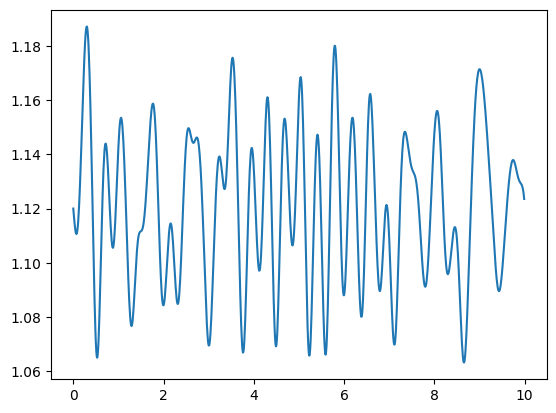

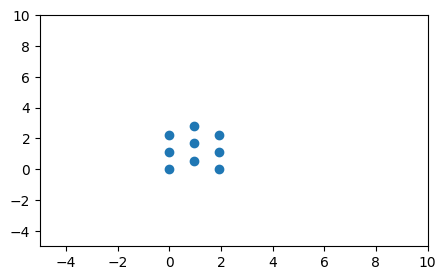

In [34]:
M = 9           # Number of particles
dt = 0.01       # Timestep
t_end = 10      # Final time
N = t_end/dt    # Number timesteps
V0 = 0.5        # Initial velocity
r0 = 1.12*a     # Distance between particles

pos0 = hexagon_IC(M, r0)

#creates an ndarray with constant velocity V0 and random direction 
rand = np.random.uniform(0,1,(M))
vel0 = np.zeros((M,2))
vel0[:,0] += rand
vel0[:,1] += (1-rand)
direction = np.random.choice((1,-1),(M,2))
vel0 = vel0 * V0 * direction
##################################################################

particle_arr = Particle_array(M, pos0, vel0)

# Plots the distance between 2 particles
plt.figure()
t = np.arange(0,t_end,dt)
particle_arr.verlet(t_end,dt)
R = np.linalg.norm(particle_arr.positions_log[:,int(M/2)-1,:] - particle_arr.positions_log[:,int(M/2),:],axis=1)
plt.plot(t,R)

anim = particle_arr.animate(t_end, dt)
HTML(anim.to_jshtml())

anim.save('9.gif')
